In [79]:
import pandas as pd
import numpy as np
import unidecode
import re

In [80]:
# Read in data, drop columns we don't plan to use
data = pd.read_csv("data/winemag-data-130k-v2.csv", encoding='utf-8')
data.drop([data.columns[0], 'designation', 'taster_twitter_handle'], axis=1, inplace=True)

In [81]:
# Remove special characters, replacing them with their English counterparts. 
# Transform all text to lower case, remove non letters/whitespace
def func(x):
    try: 
        return unidecode.unidecode(x).lower() 
    except: 
        return x
for col in data.columns:
    data[col] = data[col].apply(func)
data['description'] = data['description'].apply(lambda x: re.sub("[^a-z ]","", re.sub("-", " ", x))).apply(lambda x:
                                                                                                        '<s> ' + x + ' </s>')

In [82]:
# Create output variable(s). Select only top 30 varietals/regions and classify others as 'other'
chosen = list(data['variety'].value_counts()[0:30].index)
def label_row(row):
    if row['variety'] in chosen:
        return row['variety']
    return 'other'
data['y_variety'] = data.apply (lambda row: label_row(row),axis=1)
chosen = list(data['province'].value_counts()[0:30].index)
def label_row(row):
    if row['province'] in chosen:
        return row['province']
    return 'other'
data['y_province'] = data.apply (lambda row: label_row(row),axis=1)

In [83]:
# Separate into test and training
data = data.drop_duplicates()
trainRaw = data.sample(n=100000, replace=False, random_state=1)
test_val = data.drop(trainRaw.index)
testRaw = test_val.sample(frac=0.5, replace=False, random_state=1)
valRaw = test_val.drop(testRaw.index)

In [8]:
trainRaw.to_json("train.json",orient='records')
testRaw.to_json("test.json",orient='records')

### Create GloVe matrix

In [ ]:
from mittens import GloVe
from mittens import Mittens
import pandas as pd
import nltk
import csv
import re
import operator

# Reading in data

data = pd.read_json('train.json')
descriptions = data['description']

# Parsing each review

reviews = []
for d in descriptions:
	words = d.split()
	words.append("</s>")
	words.insert(0, "<s>")
	reviews.append(words)

# Creating vocabulary

vocab = {}
for r in reviews:
	for w in r:
		if w in vocab:
			vocab[w] += 1
		else:
			vocab[w] = 1

sort = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)[:5000]
top_5k = {}
counter = 0
for word, _ in sort:
	top_5k[word] = counter
	counter += 1

np.save('5k_vocab_dict.npy', top_5k) 

# Initializing co dict

co_dict = {}
for r in reviews:
    for i in range(len(r)):
		currWord = r[i]

		if currWord not in top_5k:
			continue

		for other_i in range(-5, 6):

			if ((i + other_i) < 0) or ((i + other_i) >= len(r)) or (other_i == 0) or (r[i + other_i] not in top_5k):
				continue

			otherWord = r[i + other_i]
			dist_weight = 1. / abs(other_i)

			if other_i < 0:
				if (otherWord, currWord) in co_dict:
					co_dict[(otherWord, currWord)] += dist_weight
				else:
					co_dict[(otherWord, currWord)] = dist_weight

			else:
				if (currWord, otherWord) in co_dict:
					co_dict[(currWord, otherWord)] += dist_weight
				else:
					co_dict[(currWord, otherWord)] = dist_weight

# Creating co-occurance matrix

co_matrix = np.zeros((5000, 5000))
for word1, word2 in co_dict.keys():
    co_matrix[top_5k[word1], top_5k[word2]] = co_dict[(word1, word2)]

def glove2dict(glove_filename):
    with open(glove_filename) as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        embed = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    return embed

# Training GloVe

original_embeddings = glove2dict("glove.6B/glove.6B.200d.txt")
vocab_array = vocab.keys()
mittens_model = Mittens(n=200, max_iter=2000)
new_embeddings = mittens_model.fit(co_matrix, vocab = top_5k.keys(), initial_embedding_dict = original_embeddings)

np.save('GloVe_wine_5k.npy', new_embeddings) 

### Models

In [84]:
# Load glove matrix and convert to embedding format
vectors = np.load("data/GloVe_wine_5k.npy")
words = np.load('data/5k_vocab_dict.npy').item()
EMBEDDING_DIM = len(vectors[0])
embedding_dict = {}
for k,v in words.items():
    embedding_dict[k] = vectors[v]

In [85]:
texts = list(trainRaw['description'])
texts_val = list(valRaw['description'])
texts_test = list(testRaw['description'])
labels = list(trainRaw['y_variety'])

In [86]:
# Tokenize text and pad to make inputs uniform
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH=136

tokenizer = Tokenizer(num_words=len(vectors), filters=[])
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
sequences_val = tokenizer.texts_to_sequences(texts_val)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [9]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [87]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        

In [88]:
# Convert output variable into categorical representation
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(trainRaw['y_variety']))
labels = le.transform(trainRaw['y_variety'])
labels_val = le.transform(valRaw['y_variety'])
labels_test = le.transform(testRaw['y_variety'])
keys = list(le.classes_)
vals = le.transform(keys)
labels_index = dict(zip(keys,vals))

In [89]:
from keras.layers import *
from keras.models import Model
from keras.utils import to_categorical
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

encoding = to_categorical(labels)
encoding_val = to_categorical(labels_val)
encoding_test = to_categorical(labels_test)

In [ ]:
# LSTM Model
from keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam
encoding = to_categorical(labels)
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(100)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='softmax'))
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())
model.fit(data, encoding, epochs=20, verbose=2, validation_data=(data_val_s, encoding_val_s), batch_size=250)
model_json = model.to_json()
with open("model_100_dense.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_100_dense.h5")
print("Saved model to disk")

In [54]:
import os
from keras.models import model_from_json
# load json and create model
json_file = open('model_100_dense.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_100_dense.h5")
print("Loaded model from disk")

Loaded model from disk


In [55]:
data_val_s = data_val[:-244,]
encoding_val_s = encoding_val[:-244,]
data_test_s = data_test[:-244,]
encoding_test_s = encoding_test[:-244,]
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(data_test_s, encoding_test_s, verbose=0, batch_size=250)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 63.64%


In [69]:
y_prob = loaded_model.predict(data_test_s, batch_size=250) 
y_classes = y_prob.argmax(axis=-1)

Text(0,0.5,'actual')

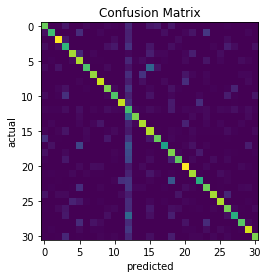

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
plt.imshow(pd.crosstab(y_classes, labels_test[:-244]).apply(lambda r: r/r.sum(), axis=1))
plt.title('Confusion Matrix')

plt.xlabel('predicted')
plt.ylabel('actual')

In [157]:
valRaw.iloc[pos]['description'].iloc[3]

'<s> produced from vines that are up to  years old this is a firmly structured wine concentration and dry tannins come from some firm extraction the fruit though is ripe and juicy showing red berry flavors along with spice from the wood aging drink the wine from  </s>'

In [21]:
labels_index

{'bordeaux-style red blend': 0,
 'bordeaux-style white blend': 1,
 'cabernet franc': 2,
 'cabernet sauvignon': 3,
 'champagne blend': 4,
 'chardonnay': 5,
 'gamay': 6,
 'gewurztraminer': 7,
 'gruner veltliner': 8,
 'malbec': 9,
 'merlot': 10,
 'nebbiolo': 11,
 'other': 12,
 'pinot grigio': 13,
 'pinot gris': 14,
 'pinot noir': 15,
 'portuguese red': 16,
 'portuguese white': 17,
 'red blend': 18,
 'rhone-style red blend': 19,
 'riesling': 20,
 'rose': 21,
 'sangiovese': 22,
 'sauvignon blanc': 23,
 'shiraz': 24,
 'sparkling blend': 25,
 'syrah': 26,
 'tempranillo': 27,
 'viognier': 28,
 'white blend': 29,
 'zinfandel': 30}